## Reglas

El universo (o entorno) del Juego de la Vida es infinito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de 4 posibles estados, flamable (0), no flamable (1), en fuego (2) o quemada (3). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda con un vecino en fuego tiene una probabilidad de quemarse.
2. Despues de un cierto numero de turnos en fuego, las celdas queman todo el combustible y ya no pueden propagar el fuego.

In [1]:
!python3 -m pip install mesa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.8/240.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [83]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [135]:
class CellAgent(Agent):
    """
    Representa a un agente o una celda con estado flamable (0), non flamable (1), en fuego (2) o quemada (3)
    """
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        if(unique_id[0] == 0 and unique_id[1] == 0):
            self.state = 2
        else:
            random = np.random.randint(0,100)
            self.state = 1 if random <= 35 else 0
        self.burned_steps = 0;
        self.next_state = None

    def step(self):
        """
        Este método es el que calcula el estado de la celda dependiendo el estado de sus vecinos.
        La idea consiste en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)
        
        self.next_state = self.state
        
        if(self.next_state == 2):
            self.burned_steps += 1
            if(self.burned_steps > 3):
                self.next_state = 3
        
        elif(self.next_state == 0):
            for neighbor in neighbours:
                if(neighbor.state == 2):
                    random = np.random.randint(0,100)
                    if(random <=  25):
                        self.next_state = 2;

    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.state = self.next_state

class ForestFireModel(Model):
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        # se importa arriba: import random
        # celdas = model.grid.coord_iter()
        # celdas_con_arboles = random.sample(celdas, k=25)
        # posiciones_arboles = [pos for _, pos in celdas_con_arboles]

        for (content, pos) in self.grid.coord_iter():
            # if pos in posiciones_arboles
                # código para instanciar árbol

            a = CellAgent(pos, self)
            self.grid.place_agent(a, pos)
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "OnFire": self.get_on_fire,
                             "Flamable": self.get_flamable}
        )

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, pos = cell
            x, y = pos
            grid[x][y] = cell_content.state

        return grid

    def get_on_fire(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, CellAgent):
                total_live_agents += 1 if agent.state == 2 else 0

        return total_live_agents
    
    def get_flamable(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, _ = cell
            if isinstance(agent, CellAgent):
                total_live_agents += 1 if agent.state == 0 else 0

        return total_live_agents

# Ejecución del modelo
A continuación corremos el modelo

In [136]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = ForestFireModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:01.790794


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [137]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [138]:
all_grids

,Grid,OnFire,Flamable
0,"[[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1,6360
1,"[[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3,6358
2,"[[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",8,6353
3,"[[2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",11,6350
4,"[[3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",13,6347
5,"[[3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16,6342
6,"[[3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",23,6330
7,"[[3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",37,6313
8,"[[3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",45,6302
9,"[[3.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",57,6285


In [139]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

colors = []
colors.append(np.array([124 / 255, 252 / 255, 0 / 255, 1])) #flamable
colors.append(np.array([20 / 255, 20 / 255, 255 / 255, 1])) #no flamable
colors.append(np.array([255 / 255, 20 / 255, 20 / 255, 1])) #fuego
colors.append(np.array([0 / 255, 0 / 255, 0 / 255, 1])) #quemado
colormap = mlp.colors.ListedColormap(colors)

patch_grid = axs.imshow(all_grids['Grid'].iloc[0], cmap=colormap, vmin=0, vmax=3)

cells_alive = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_alive.append(all_grids['OnFire'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [140]:
anim

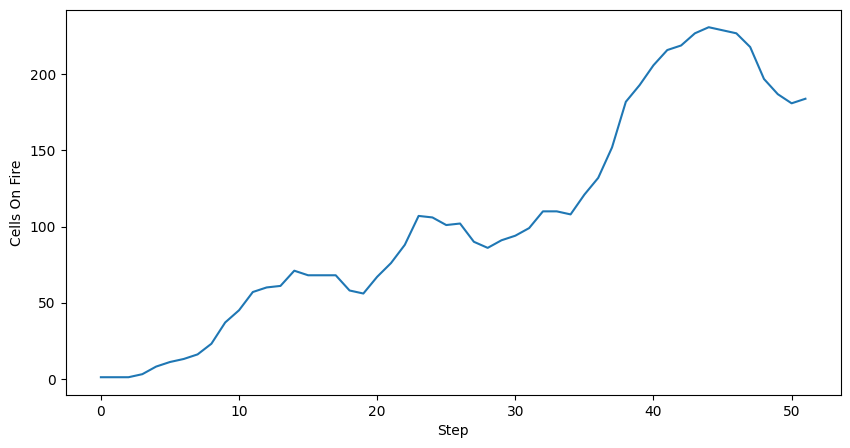

In [141]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells On Fire")

plt.plot(cells_alive)
plt.show()

# Batch simulation

In [142]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 100

model = ForestFireModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], onFire=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['onFire'].append(all_grids['OnFire'].to_numpy())


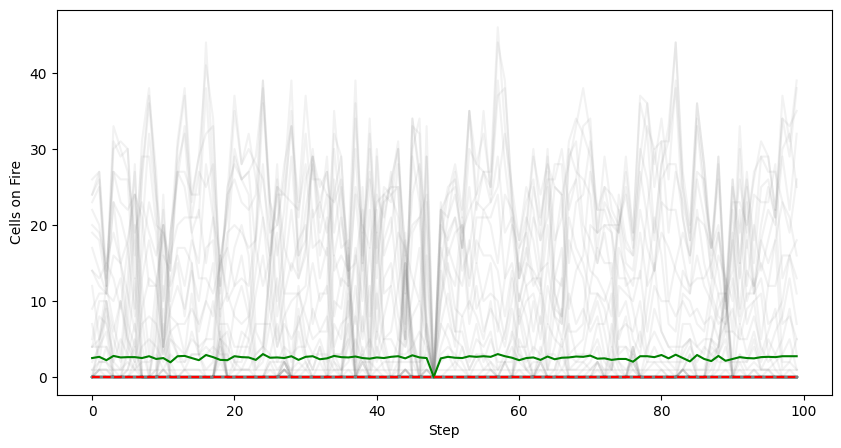

In [143]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells on Fire")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['onFire'], color='Grey', alpha=0.1)

plt.plot(np.average(np.array(batch_data['onFire']), axis=1), color='Green')
plt.plot(np.median(np.array(batch_data['onFire']), axis=1), color='Red', linestyle='dashed')

plt.show()